In [20]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator 

from statsmodels.tsa.stattools import adfuller, pacf, acf
from scipy.stats import shapiro, probplot # shapiro wilk test for normality sample size thousands or fewer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.arima_model import ARIMA

# Import Data

In [41]:


def importdata(key, path ,parseCol, From="2004-01-01", To="2019-09-01"):
    ''' 
    make sure the end date of the parse is shared between all datasets
    '''
    dataset = pd.read_csv("%s" %(path), index_col="%s" %(parseCol), parse_dates=["%s" %(parseCol)])
    if From==None and To==None:
        pass
    elif From and To:
        dataset = dataset.loc[From:To]
    return dataset


import_PATH = r"C:\Users\sherv\OneDrive\Documents\GitHub\Python - Projects\Research Project\Data"    
meta = {# dataset: [path, Date_col, Value_col]
        "Google":[f"{import_PATH}\multiTimeline.csv", "Month", "Top5"], 
#        "RDPI":  [f"{import_PATH}\RealDisposableIncome-2004-1_Present-Mon-US(Grab-30-11-18).csv", "DATE", "DSPIC96"], 
#        "CPI":   [f"{import_PATH}\CPI.csv", "DATE", "CPI"],
#        "GDP":   [f"{import_PATH}\GDP.csv", "DATE", "GDP"], 
#        "UE":    [f"{import_PATH}\Unemployment_2004_Present_US(Grab-5-12-18).csv", "DATE", "Value"], 
        "SP500": [f"{import_PATH}\S&P500.csv", "Date", "Close"], 
#        "IR":    [f"{import_PATH}\InterestRate_2004-1-1_Present_US(Grab-5-12-18).csv", "DATE", "FEDFUNDS"], 
#        "PPI":   [f"{import_PATH}\PPIACO.csv", "DATE", "PPI"],
#        "PMI":   [f"{import_PATH}\ISM-MAN_PMI.csv", "Date", "PMI"],
        "DJI":   [f"{import_PATH}\DJI.csv", "Date", "Close"]} 

data ={}
for key in meta.keys():
    data[key] = importdata(key, meta[key][0], meta[key][1])

# Visualise Data

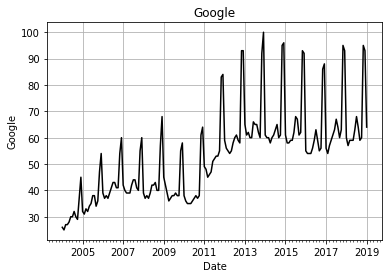

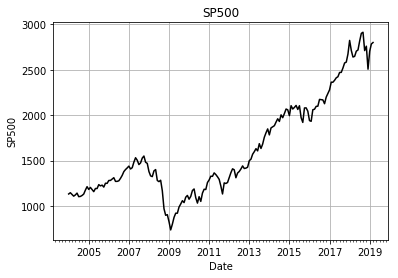

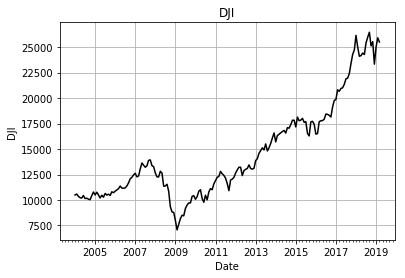

In [42]:

save_PATH = r"C:\Users\sherv\OneDrive\Documents\GitHub\Python - Projects\Research Project\Plots_Main"
minor_locator = AutoMinorLocator(12)
for key in data.keys():
    fig, ax1 = plt.subplots()
    data[key][meta[key][2]].plot(ax=ax1,color='k').xaxis.set_minor_locator(minor_locator)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(key, color='k')
    plt.grid()
    Title = f"{key}"
#     ax2 = ax1.twinx()
#     data[key2][array2].plot(ax=ax2,color='r')
#     ax2.set_ylabel(array2, color='r')
#     ax2.tick_params('y', colors='r')
    plt.title(Title)
#    plt.savefig("%s\%s.png" %(save_PATH, Title))

1. Google data is limited to the dates ["2004-01-01":"2019-09-01"]
2. data undergoes structural break from 2008 to 2009 so model is best to be fit from 2009 onwards
3. train data is to be 95% of available data after parse

In [43]:
SP = data["SP500"]["Close"].loc["2009-01-01":"2018-12-01"]
DJI= data["DJI"]["Close"].loc["2009-01-01":"2018-12-01"]
GGL = data["Google"][meta["Google"][2]].loc["2009-01-01":"2018-12-01"]

# Differencing

1. Is variance constant over time? 
- Plot yearly variance (or growth rate), If growth present take logarithm
2. Is there seasonality?
- plot month's data over the years in box plot to compare seasonality
3. Is data stationary? 
- If ADF test, If no difference until stationary


# __In this section, to make the variance comparable and a relatable metric, the variances were normalised by variance.max(). Is this correct?__

#### Variance Growth

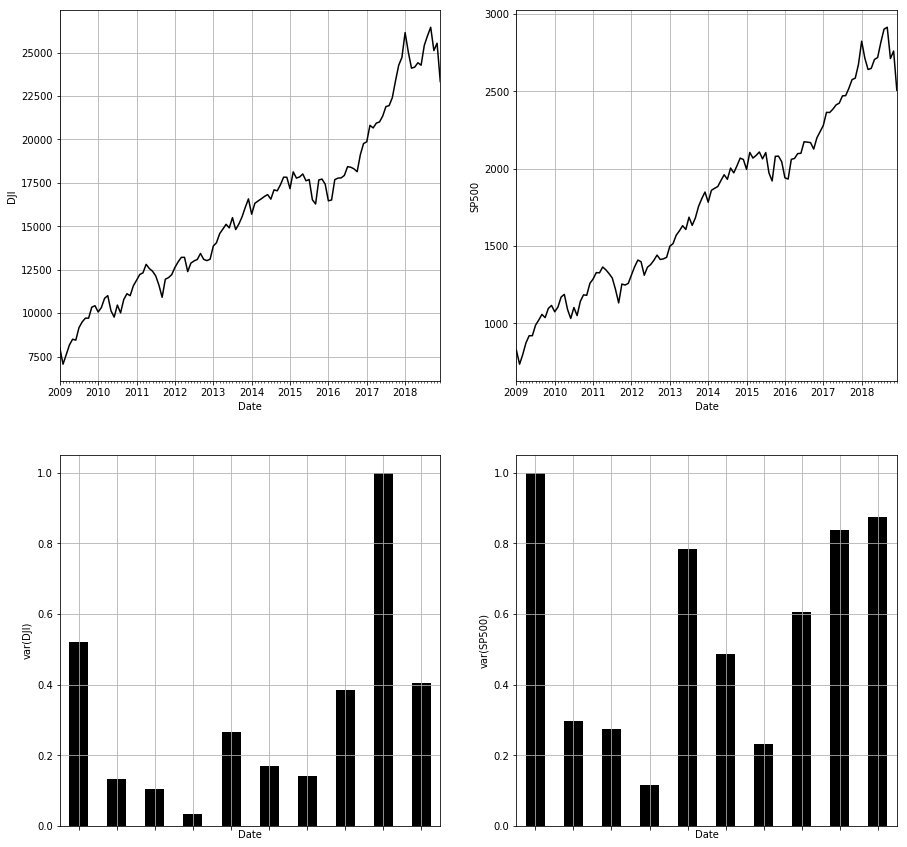

In [44]:
def var_growth_check(df):
    df_years = {}
    mm = [M for M in range(12)]
    for year in range(len(df)//12):
        val = []
        for M in mm:
            val.append(df.iloc[year*12+M])
        df_years[year] = val
    df_years = pd.DataFrame.from_dict(df_years)
    return df_years

DJI_year_var = var_growth_check(DJI)
SP_year_var = var_growth_check(SP)

fig, axes = plt.subplots(2,2,figsize=(15,15))
DJI.plot(ax=axes[0, 0], grid=True, color="k").xaxis.set_minor_locator(minor_locator)
axes[0,0].set(ylabel="DJI", xlim=["2009-01-01" , "2018-12-01"])
SP.plot(ax=axes[0, 1], grid=True, color="k").xaxis.set_minor_locator(minor_locator)
axes[0,1].set(ylabel="SP500", xlim=["2009-01-01" , "2018-12-01"])

# DJI.rolling(12, center=False).var().plot(ax=axes[1, 0],grid=True, color="b", kind="bar")
(DJI_year_var.var()/DJI_year_var.var().max()).plot(ax=axes[1, 0],grid=True, color="k", kind="bar") # is this normalisationcorrect
axes[1, 0].set(xlabel="Date", ylabel="var(DJI)")
axes[1, 0].tick_params(labelbottom=False)

# SP.rolling(12, center=False).var().plot(ax=axes[1, 1],grid=True, color="b", kind="bar")
(SP_year_var.var()/SP_year_var.var().max()).plot(ax=axes[1, 1],grid=True, color="k", kind="bar")# is this normalisationcorrect
axes[1, 1].set(xlabel="Date", ylabel="var(SP500)")
axes[1, 1].tick_params(labelbottom=False)


#### Seasonality

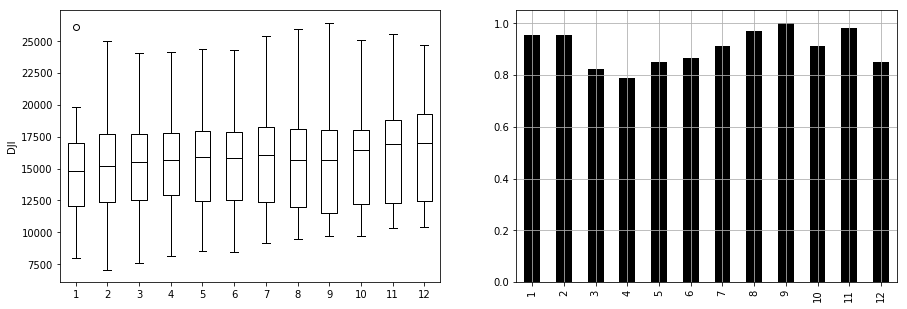

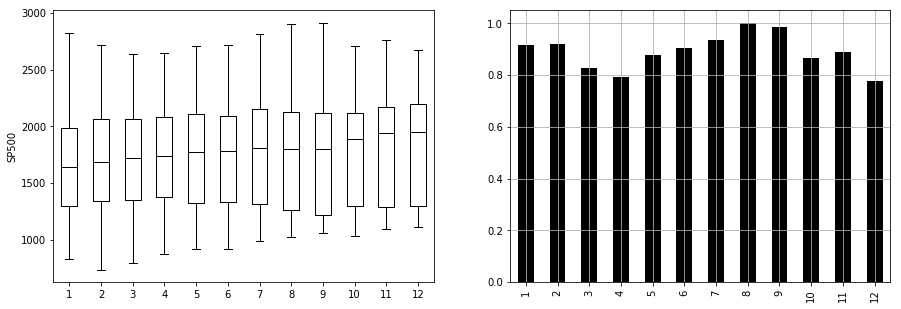

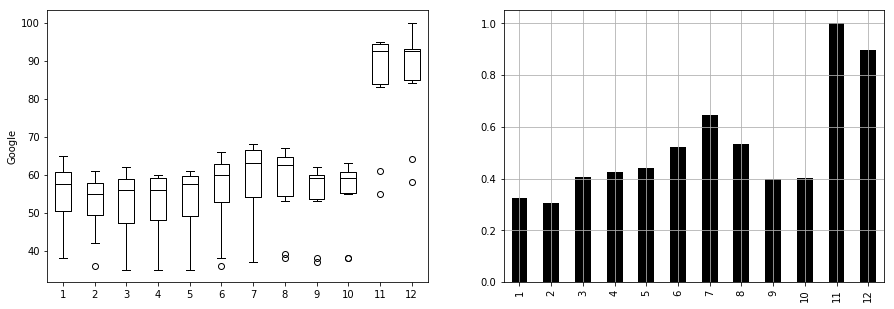

In [45]:
def seasonality_check(DF, Title, key=None, array=None, ):
    """
    data must not include incomplete years. 
    """
    if key and array: #check this line later
        df = data[key][array]
    else:
        df = DF
    mm = [M for M in range(1,13)]
    df_by_month = {}
    for M in mm:
        val = []
        for year in range(len(df)//12):
            val.append(df.iloc[year*12+M-1])
        df_by_month[M] = val
    df_by_month = pd.DataFrame.from_dict(df_by_month)    
    
    fig, axes = plt.subplots(1,2, figsize=(15,5))    
    df_by_month.plot(ax=axes[0], kind="box" , color="k")
    (df_by_month.var()/df_by_month.var().max()).plot(ax=axes[1], kind="bar", grid=True, color="k") # is this normalisation correct?
    axes[0].set(ylabel=f"{Title}")
    return df_by_month


DJI_by_month = seasonality_check(DJI, "DJI")
SP_by_month = seasonality_check(SP, "SP500")
GGL_by_month = seasonality_check(GGL, "Google")

#### ACF/PACF


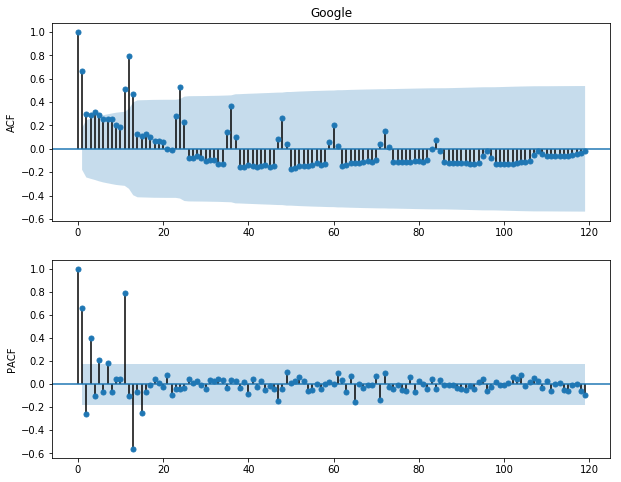

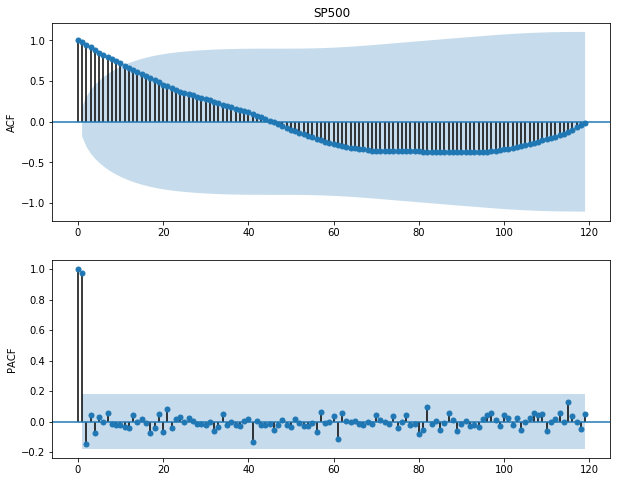

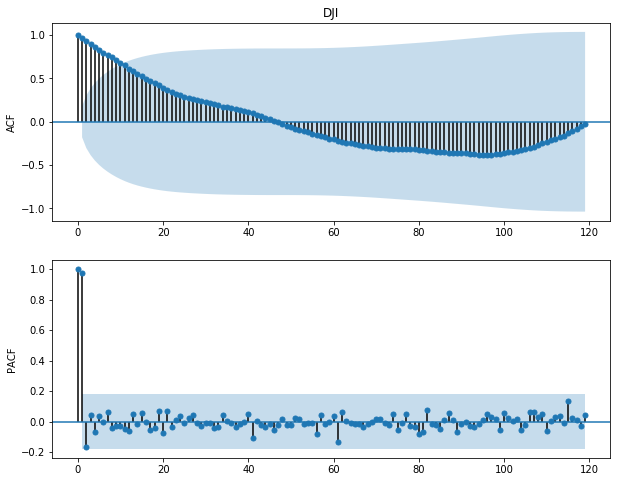

In [90]:
def acf_pacf(data, Title):
    fig, axes = plt.subplots(2,1, figsize=[10,8])
    plot_acf(data, ax=axes[0], title=f"{Title}")
    axes[0].set(ylabel="ACF")
    plot_pacf(data, method="ywmle", ax=axes[1], title="")
    axes[1].set(ylabel="PACF")
    
acf_pacf(GGL, "Google");
acf_pacf(DJI, "DJI");
acf_pacf(SP, "SP500");


[Text(0,0.5,'PACF')]

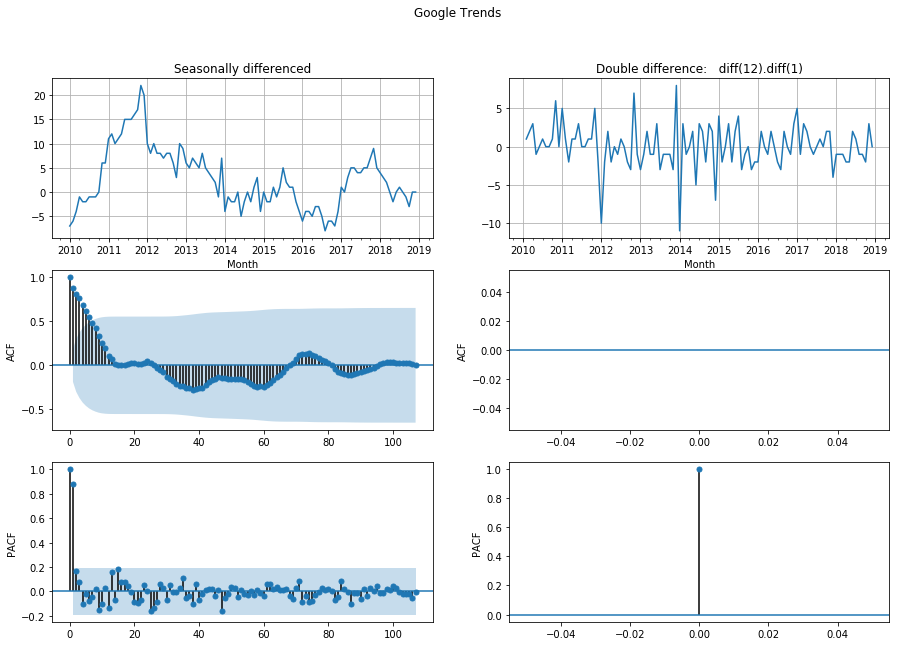

In [92]:
fig, axes = plt.subplots(3,2, figsize=[15,10])
fig.suptitle("Google Trends")
seasonal_diff = GGL.diff(12).dropna()
seasonal_diff.plot(ax=axes[0,0], grid=True, title="Seasonally differenced")
plot_acf(seasonal_diff, ax=axes[1,0], title="");
axes[1,0].set(ylabel="ACF")
plot_pacf(seasonal_diff, method="ywmle", ax=axes[2,0], title="");
axes[2,0].set(ylabel="PACF")

double_diff = GGL.diff(12).diff(1)
double_diff.plot(ax=axes[0,1], grid=True, title="Double difference:   diff(12).diff(1)")
plot_acf(double_diff, ax=axes[1,1], title="");
axes[1,1].set(ylabel="ACF")
plot_pacf(double_diff, method="ywmle", ax=axes[2,1], title="");
axes[2,1].set(ylabel="PACF")


Of course, the data is non-stationary and differencing will be carried out. It can be seen that the google data is deifinitely seasonal and must be decomposed. The indices also show increased volatility first and third quarter thus log differencing will be applied. 

# SARIMA(p,d,q)(P,D,Q)$_m$

90% of the data is chosen as a training set and the remainder can be used as an in sample test of the fit.

# Residual Test

we need to test for normality and AC in residuals. 

# VAR

# Forecast horizon

# Forecasting (KMC)